In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Code specific to Google Colab
    print("Running in Google Colab")

    # Additional setup commands for Colab
    !pip install neuralforecast
    !pip install gymnasium
else:
    # Code for other environments (e.g., VS Code)
    print("Running in another environment (e.g., VS Code)")

Running in another environment (e.g., VS Code)


In [79]:
if IN_COLAB:
    # Retrive required files
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/environments/stockenv.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/cleandata.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/data.py
    # Move all directories and files from content/raw.githubusercontent.com to content/
    !mv /content/raw.githubusercontent.com/* /content/

    # Delete the raw.githubusercontent.com directory
    !rm -rf /content/raw.githubusercontent.com

In [3]:
import sys
import os
import torch
import random
import pickle
import itertools
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utilities.cleandata as cln
from utilities.data import UniStockEnvDataStruct
from environments.stockenv import ContinuousOHLCVEnv
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TimesNet
from neuralforecast.losses.numpy import mae, mse
from datetime import datetime

os.environ['NIXTLA_ID_AS_COL'] = '1'


def set_seed(seed):
    """Set seed for reproducibility."""
    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)

    # If you are using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        # Additional settings to force determinism in your operations:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [26]:
RANDOM_SEED = 42
set_seed(RANDOM_SEED)

if not IN_COLAB:
    pwd = "C:/programming/MADDQN"
    sys.path.append(pwd)

# Input Data Location, File Name, Stock name for labels
input_url = 'https://raw.githubusercontent.com/CodeBeckZero/MADDQN/main/input_data'

stock_inputs ={'DJI':'^DJI_daily.csv',
               'NDAQ': '^IXIC_daily.csv',
               'SP500': '^SPX_daily.csv',
               'AAPL': 'AAPL_daily.csv',
               'AMZN': 'AMZN_daily.csv',
               'GOOGL': 'GOOGL_daily.csv',
               'MSFT': 'MSFT_daily.csv',
               'SINE': 'sine_wave_daily.csv',
               'FORD': 'F_daily.csv',
               'JNJ': 'JNJ_daily.csv',
               'NEE': 'NEE_daily.csv',
               'PFE': 'PFE_daily.csv',
               'TSLA': 'TSLA_daily.csv',
               'COKE': 'COKE_daily.csv',
               'PG': 'PG_daily.csv'}

# Training Inputs
trn_keys = ['DJI','NDAQ','SP500']
training_range = ('2007-01-03','2020-12-31')
trn_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in training_range]

# Validation Inputs
val_keys = trn_keys
validation_range = ('2021-01-04','2023-12-28')
val_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in validation_range]

# Testing Inputs
tst_keys = list(stock_inputs.keys())
testing_range = ('2007-01-03','2023-12-28')
tst_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in testing_range]

window_size = 28 # Window size
n_prediction = 5 # Number points to predict in the future
price_based_on = 'close'
columns = ['open','high','low','close','volume']

import_dataset = False




In [27]:
if import_dataset:
    if IN_COLAB:
        !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/gen_data/unidata.pkl
        with open(pwd+"./contents/unidata.pkl", "rb") as file:
            env = pickle.load(file)
    else:
        with open(pwd+"/gen_data/unidata.pkl", "rb") as file:
            env = pickle.load(file)

else:
    env = {}

    for name, file in stock_inputs.items():
        if name in set(trn_keys + val_keys + tst_keys):
            # Import
            df = cln.YAHOO_csv_input(file, input_url)
            data_dic = UniStockEnvDataStruct(df,price_based_on,window_size)
            env[name] = data_dic
            
    if IN_COLAB:
        with open('unidata.pkl', 'wb') as file:
            pickle.dump(env, file)
    else:
        with open(pwd+'/gen_data/unidata.pkl', 'wb') as file:
            pickle.dump(env, file)

In [30]:
display(env['PG']['rw_long_wstd_price'][5])

ds unique_id         y
5  2007-01-10     close -1.608848
6  2007-01-11     close -0.740458
7  2007-01-12     close  0.041093
8  2007-01-16     close  0.041093
9  2007-01-17     close  0.822645
10 2007-01-18     close  1.213421
11 2007-01-19     close  2.407458
12 2007-01-22     close  1.604196
13 2007-01-23     close  1.430518
14 2007-01-24     close  1.148291
15 2007-01-25     close -0.132585
16 2007-01-26     close -0.262843
17 2007-01-29     close -0.219424
18 2007-01-30     close -0.849007
19 2007-01-31     close -0.241133
20 2007-02-01     close  0.779225
21 2007-02-02     close  0.779225
22 2007-02-05     close  0.366740
23 2007-02-06     close -0.849007
24 2007-02-07     close -1.087814
25 2007-02-08     close -0.849007
26 2007-02-09     close -1.196363
27 2007-02-12     close -1.782527
28 2007-02-13     close -0.588490
29 2007-02-14     close -0.219424
30 2007-02-15     close  0.019384
31 2007-02-16     close  0.193062
32 2007-02-20     close -0.219424

In [ ]:
trn_env = {}
tst_env = {}

for name in trn_keys:
    data = env[name]['long_raw_price']
    data_idx = data[(data['ds'] >= trn_dt_range[0]) & (data['ds'] <= trn_dt_range[1])]
    trn_env[name] = data_idx

for name in tst_keys:
    data = env[name]['long_raw_price']
    data_idx = data[(data['ds'] >= tst_dt_range[0]) & (data['ds'] <= tst_dt_range[1])]
    tst_env[name] = data_idx


In [ ]:
fig, ax = plt.subplots()

ax.plot(env['DJI']['long_df']['ds'], env['DJI']['long_df']['y'], label='close')

ax.set_xlabel('Time')
ax.set_ylabel('Y Value')

# Add legend to distinguish between different values
ax.legend()

# Rotate and align x-axis labels
fig.autofmt_xdate()

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
model = TimesNet(h = n_prediction, # Forecast horizon
                 input_size = window_size, # Length of Batches
                 batch_size = 1, # Number of timeseries to predict
                 #futr_exog_list = remaining_columns,
                 hidden_size = 128, # Size of embedding for embedding and encoders,
                 dropout = 0.40, # Dropout for embeddings
                 conv_hidden_size = 3, # Channels for the inception block
                 top_k = 5, # Top num of periods from FFT considered
                 num_kernels = 13, # number of kernels for the inception block
                 encoder_layers = 3, # num of encoders
                 max_steps = 1000, # of training steps
                 early_stop_patience_steps = 10, #early stoppage on validation
                 val_check_steps = 100, # Val check every X steps,
                 windows_batch_size = 150, # Number of windows in training epoch,
                 num_workers_loader = 7,
                 learning_rate = 0.0003,
                 random_seed = RANDOM_SEED)

c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 42


In [31]:
import_model = False

if import_model:
# Define the correct path
  if IN_COLAB:
    
    model_path = os.path.join(os.getcwd(), 'gen_data', 'timesnet')

    # Ensure the directory and file exist
    if os.path.exists(model_path):
        nf = NeuralForecast.load(path=model_path)
    else:
        raise FileNotFoundError(f"Model path {model_path} does not exist.")
else:
  
  nf = NeuralForecast(models=[model], freq='d')
  results = {}
  for key in trn_keys:
    results[key] = nf.fit(df=trn_env[key],val_size=0.2,)

  nf.save(path='./checkpoints/test_run/',
          model_index=None,
          overwrite=True,
          save_dataset=True)

c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 42


In [39]:
import_predictions = True

if import_predictions:
    if IN_COLAB:
        !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/gen_data/uni_df.pkl
        with open("./contents/uni_df.pkl", "rb") as file:
            env = pickle.load(file)
    else:
        with open(pwd+"/gen_data/unidata.pkl", "rb") as file:
            env = pickle.load(file)
  
else:

  logging.getLogger("pytorch_lightning").setLevel(logging.WARNING) # Disables printouts about GPU/TPU each time model.predict() is called

  columns = ['date', 'price', '1d','2d','3d','4d','5d']

  uni_df = {}

  for stock in tst_keys:
    df = pd.DataFrame(columns=columns)

    for window in range(len(env[stock]['rw_long_raw_price'])):

        today_date = env[stock]['rw_long_raw_price'][window]['ds'].iloc[-1]
        today_price = list(itertools.chain.from_iterable(env[stock]['rw_raw_price_env'][window]))[-1] # Flattens List of Lists of prices, final price = current price
        test = nf.predict(df=env[stock]['rw_long_raw_price'][window])
        today_prediction = test['timesnet'].to_list()
        row_to_add = {'date': today_date, 
                    'price': today_price,
                    '1d':today_prediction[0],
                    '2d':today_prediction[1],
                    '3d':today_prediction[2],
                    '4d':today_prediction[3],
                    '5d':today_prediction[4]}
        # Convert the row dictionary to a DataFrame
        row_df = pd.DataFrame([row_to_add])

        # Add the row to the DataFrame using pd.concat()
        df = pd.concat([df, row_df], ignore_index=True)


    df['1d'] = df['1d'].shift(1)
    df['2d'] = df['2d'].shift(2)
    df['3d'] = df['3d'].shift(3)
    df['4d'] = df['4d'].shift(4)
    df['5d'] = df['5d'].shift(5)

    uni_df[stock] = df

    if IN_COLAB:
        with open('uni_df.pkl', 'wb') as file:
            pickle.dump(uni_df, file)
    else:
        with open(pwd+'/gen_data/uni_df.pkl', 'wb') as file:
            pickle.dump(uni_df, file)







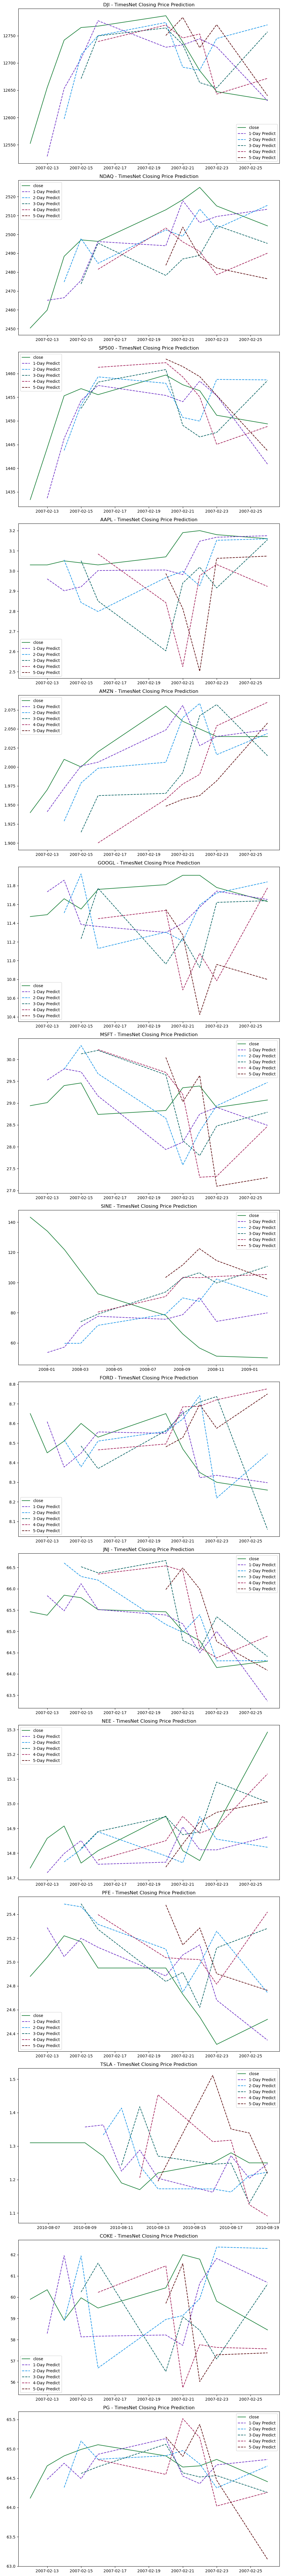

In [37]:
# Assuming 'uni_df' is your dictionary
num_subplots = len(uni_df.keys())

# Create subplots
fig, axes = plt.subplots(num_subplots, figsize=(10, 6*num_subplots))

# Iterate over keys and corresponding dataframes to plot
for i, (key, df) in enumerate(uni_df.items()):
    ax = axes[i] if num_subplots > 1 else axes  # For multiple subplots, use axes[i], otherwise axes
    ax.plot(df['date'], df['price'], label='close', color='#198038')
    ax.plot(df['date'], df['1d'], label='1-Day Predict', linestyle='--', color='#6929c4')
    ax.plot(df['date'], df['2d'], label='2-Day Predict', linestyle='--', color='#1192e8')
    ax.plot(df['date'], df['3d'], label='3-Day Predict', linestyle='--', color='#005d5d')
    ax.plot(df['date'], df['4d'], label='4-Day Predict', linestyle='--', color='#9f1853')
    ax.plot(df['date'], df['5d'], label='5-Day Predict', linestyle='--', color='#570408')
    ax.set_title(f"{key} - TimesNet Closing Price Prediction")  # Set subplot title
    ax.legend()


plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


